In [1]:
%matplotlib inline

In [104]:
# Imports
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from math import sqrt

# Constants
IMAGE_SIZE = 48

# Facial Emotion Recognition

#### 1. Dataset Collection

For this project, we will use the `FER-2013 Dataset`. It is a large publicly available dataset that contains 35,887 grayscale images of facial expressions categorized into seven emotions (anger, disgust, fear, happiness, sadness, surprise, and neutral). The dataset provides a good balance of images across different emotions. FER-2013 is a publicly accessible dataset, which means that it is free to use and safe for this project.

You can download the dataset from [kagge](https://www.kaggle.com/datasets/deadskull7/fer2013).
<br />
*If you want the program to run smoothly, download the file from the link provided and put it in the* `/dataset`  *directory, making sure the file name is* `fer2013.csv`.

First, let's load the data into `Pandas`.

In [12]:
face_data = pd.read_csv('dataset/fer2013.csv')
face_data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


As we can see, we have successfully added the dataset to Pandas. We even managed to see some information about the first 10 pictures. By the result we get, we can see the photo number, emotion label index, pixels and usage.

Here is the mapping of the emotion labels in the FER-2013 dataset:
0. Angry
1. Disgust
2. Fear
3. Happy
4. Sad
5. Surprise
6. Neutral

Now, to make sure the dataset contains real faces and not random images, let's try rendering one of them using just the pixels! This sounds like a pretty interesting problem.

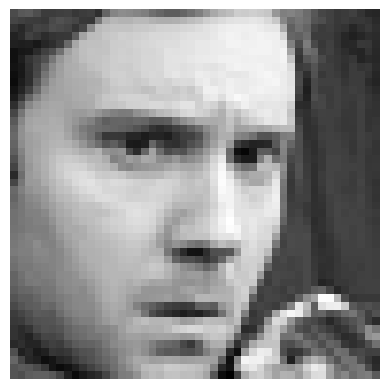

In [94]:
# First, we need to select the pixel values of the desired image 
pixels = face_data['pixels'][0] # Feel free to change the last number

# Now we need to convert the pixel values from string to a NumPy array
pixels_array = np.array(pixels.split(), dtype='uint8')

# Reshape the pixel array to match the dimensions of the image 
# Note that in the FER-2013 dataset, each image has a size of 48x48 pixels
image = pixels_array.reshape(IMAGE_SIZE, IMAGE_SIZE)

# And finally display the image using matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

If we want to use it as a function we can do something like this:

In [92]:
# Note that we want this function to be as flexible as possible
def display_face_data(dataset, index_column_name, image_index, image_size):
    pixels = dataset[index_column_name][image_index]
    pixels_array = np.array(pixels.split(), dtype="uint8")
    image = pixels_array.reshape(image_size, image_size)
    
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

And now let's try using this function with some random values:

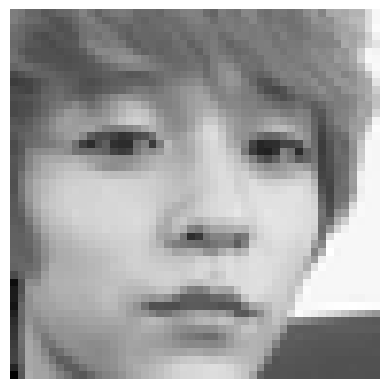

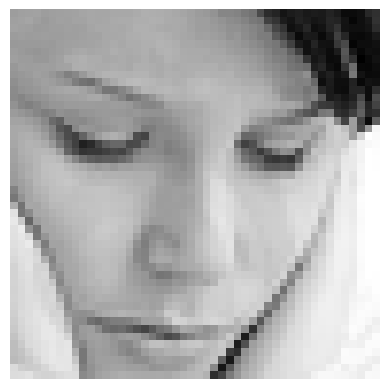

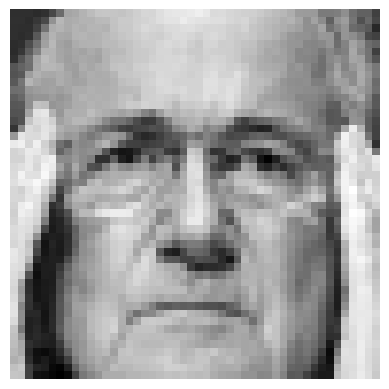

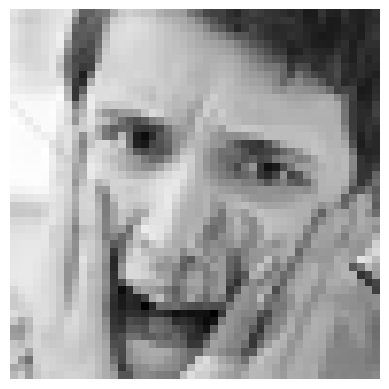

In [95]:
display_face_data(face_data, 'pixels', 13, IMAGE_SIZE)
display_face_data(face_data, 'pixels', 42, IMAGE_SIZE)
display_face_data(face_data, 'pixels', 69, IMAGE_SIZE)
display_face_data(face_data, 'pixels', 73, IMAGE_SIZE)

We could even try to break it! :D

In [38]:
# First, let's try to abuse the image size (comment out the lines of code to try)

# display_face_data(face_data, 'pixels', 101, 1) # What if it's 1?
# display_face_data(face_data, 'pixels', 101, 96) # What if it's double on size?
# display_face_data(face_data, 'pixels', 13, -48) # What if the number is negative?

# as we can see, matplotlib does not allow us to do such a simple thing. 
# Interesting, we learned a bit more about the behavior of matplotlib :D

# Now, what would happen if we want to access a non-existing image? (comment out to try)

# display_face_data(face_data, 'pixels', 50000, 48)

# As we can see, we get an exception! This is a very good behavior for a function (in programming!)

If we want to know the exact number of images in this dataset, we can always check its shape.

In [39]:
face_data.shape

(35887, 3)

As we can see, 35887 rows by 3 columns (emotion, pixels, usage). Now that we could safely say, that we know our dataset, we could preprocess it!

#### 2. Preprocessing

We need to preprocess the facial images to enhance their quality and extract relevant features. We will do it using `eigenvectors`, specifically for the task of facial expression recognition with `Eigenfaces`.


In [45]:
# First, we will extract the pixel values and emotion labels from the dataset
pixels = face_data['pixels'].values
emotions = face_data['emotion'].values

After loading the `FER-2013` dataset into the `face_data` DataFrame, we can access specific columns using their column names. The `pixels` column contains the pixel values of each facial image in the dataset. We extract these values using the `values` attribute, which returns the values of the column as a NumPy array. Likewise, the `emotion` column contains the emotion labels corresponding to each facial expression. We also extract these labels as a NumPy array. *These arrays can be used to access and manipulate the pixel values and emotion labels associated with each facial image in the dataset.*

In [46]:
# Now we will convert the pixel values from strings to NumPy arrays
pixels_array = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in pixels])

In the FER-2013 dataset, the pixel values are stored as strings, with each pixel separated by a space. To convert these strings into NumPy arrays, we use a list comprehension to iterate over each pixel string in the `pixels` array and apply the `np.fromstring()` function, which converts a string representation of an array to an actual NumPy array. Here, `pixel` represents each pixel string in the pixels array, `dtype=int` specifies that the pixel values should be treated as integers, and `sep=' '` specifies that the separator between pixels is a space. The resulting NumPy array, `pixels_array`, will have the shape (number of images, number of pixels), where each row corresponds to an image and each column contains the pixel values for that image. 
<br />
In two words: we convert the pixel values from strings to NumPy arrays, which allows for easier manipulation and analysis of the image data in subsequent steps of the data preprocessing pipeline.

In [55]:
# We can see the shape of our new array
pixels_array.shape

(35887, 2304)

As we can see, we have a result, showing us 35887 *(images)*. But what could 2304 mean? Exactly, that's the number of pixels in each image. Let me show you!

In [101]:
# To do so, we will use the first image's size and compare it with the size, stated above.
size = int(pixels_array[0].size)
image = sqrt(size)
if image == IMAGE_SIZE:
    print("Yep, that is the size of the picture! (in pixels)")

In [47]:
# After that, we will compute the mean face
mean_face = np.mean(pixels_array, axis=0)

The mean face represents the average values of all the pixel values across all the facial images in the dataset. To compute the mean face, we use the `np.mean()` function from NumPy, which calculates the average along a specified axis. In this case, we calculate the mean across the rows `(axis=0)` of the `pixels_array`. By executing this step, we obtain the mean face, which serves as a reference or baseline for subsequent steps in eigenface-based facial expression recognition. The mean face represents the "typical" face in the dataset, and by subtracting it from individual faces, we can focus on the deviations or unique features that contribute to different facial expressions.

In [49]:
# Compute the covariance matrix
cov_matrix = np.cov(pixels_array.T)

The covariance matrix provides information about the relationships and variances between different features (pixel values) in the dataset. To compute the covariance matrix, we use the `np.cov()` function from NumPy, which calculates the covariance matrix of a given dataset. We pass in the transpose of `pixels_array` to compute the covariance matrix of the pixel values across different images. The resulting `cov_matrix` is a square matrix where each element represents the covariance between two different pixel values. It helps us understand the relationships and variances among the different pixel values in the dataset. **The covariance matrix is a crucial component** in eigenface-based facial expression recognition, as it forms the basis for finding the principal components *(eigenvectors)* that capture the most important information or features in the dataset.

In [57]:
cov_matrix.shape

(2304, 2304)

Does this result seem kind of similar? :D

In [50]:
# Perform eigenvalue decomposition on the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

Eigenvalue decomposition, also known as eigendecomposition, is a process that decomposes a square matrix into its eigenvectors and eigenvalues. To perform eigenvalue decomposition, we use the `np.linalg.eig()` function from NumPy, which returns the eigenvalues and eigenvectors of a given matrix. We pass in the `cov_matrix`. The resulting `eigenvalues` is an array that contains the eigenvalues of the covariance matrix, and `eigenvectors` is a matrix where each column represents an eigenvector. The eigenvalues represent the importance or magnitude of each eigenvector, while the eigenvectors capture the directions or patterns of variability in the dataset. These eigenvectors will be used to form the basis for the eigenfaces, which are the principal components that capture the most significant facial features or variations in the dataset.

In [81]:
# We could also check out the shape of the two arrays
print("The shape of the eigenvalues is:     ", eigenvalues.shape)
print("The shape of the eigenvectors is:    ", eigenvectors.shape)

The shape of the eigenvalues is:      (2304,)
The shape of the eigenvectors is:     (2304, 2304)


In [51]:
# Sort the eigenvalues and eigenvectors in descending order
eigen_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[eigen_indices]
eigenvectors = eigenvectors[:, eigen_indices]

After performing eigenvalue decomposition in the previous step, the eigenvalues and eigenvectors are not sorted in any particular order. Sorting the eigenvalues and eigenvectors is necessary to identify the most significant eigenvectors *(those with the highest eigenvalues)* that capture the most important information in the dataset. We use the `np.argsort()` function from NumPy to obtain the indices that would sort the eigenvalues in ascending order. Then, we reverse the order using the `[::-1]` slicing notation to sort them in descending order. The resulting `eigenvalues` and `eigenvectors` are sorted in descending order based on the magnitude of the eigenvalues. This sorting process is essential for selecting the top-k eigenvectors in subsequent steps, as they capture the most important facial features or variations in the dataset.

In [52]:
# Choose the top-k eigenvectors based on the desired number of dimensions to retain
k = 100  # Feel free to change the desired number of dimensions
selected_eigenvectors = eigenvectors[:, :k]

The top-k eigenvectors represent the most significant components or patterns in the dataset, which capture the majority of the important information or features. Based on your specific requirements or the desired level of dimensionality reduction, you can choose the number of dimensions `(k)` to retain. We select the top-k eigenvectors from the sorted `eigenvectors`. The slicing operation `[:, :k]` selects the first k columns (eigenvectors) from the matrix. The resulting `selected_eigenvectors` is a matrix containing the top-k eigenvectors that capture the most important facial features or variations in the dataset. *The value of k can be adjusted based on your specific requirements, computational resources, and the amount of information you want to retain in the dataset.*

In [53]:
# And finally, project the images onto the eigenspace
projected_faces = np.dot(pixels_array - mean_face, selected_eigenvectors)

Once we have selected the top-k eigenvectors (eigenfaces) in step 8, we can project the images from the dataset onto this eigenspace. To perform the projection, we subtract the mean face obtained previously from each image in the `pixels_array` and then dot product the result with the `selected_eigenvectors`. The subtraction of the mean face centers the images around zero, removing the influence of the mean face. The dot product with the `selected_eigenvectors` projects each centered image onto the eigenspace represented by the selected eigenvectors. The resulting `projected_face`s is a matrix where each row represents the projection of an image onto the eigenspace, with reduced dimensions based on the selected eigenvectors. By executing this step, we obtain the projected faces, which are the representations of the original facial images in the reduced eigenspace. These projected faces capture the essential facial features or variations that are relevant for facial expression recognition or related tasks. The dimensionality reduction achieved through the projection onto the eigenspace allows for efficient computation and analysis of the facial data.

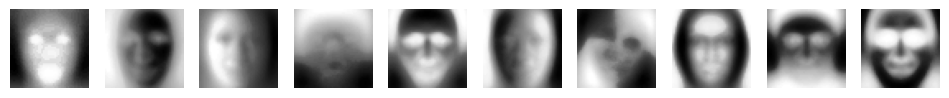

In [132]:
num_eigenfaces = 10 # The number of eigenfaces to display

# Compute the eigenface images
eigenface_images = selected_eigenvectors[:, :num_eigenfaces].T  # Transpose and select top eigenfaces
eigenface_images = eigenface_images.reshape(num_eigenfaces, IMAGE_SIZE, IMAGE_SIZE)  # Reshape into image dimensions

# Normalize eigenface images
eigenface_images = (eigenface_images - np.min(eigenface_images)) / (np.max(eigenface_images) - np.min(eigenface_images))
eigenface_images = (eigenface_images * 255).astype(np.uint8)  # Convert to uint8

# Adjust contrast and brightness
adjusted_eigenface_images = []
for i in range(num_eigenfaces):
    adjusted_image = cv2.equalizeHist(eigenface_images[i])  # Apply histogram equalization for contrast enhancement
    adjusted_image = cv2.convertScaleAbs(adjusted_image, alpha=0.5, beta=5)  # Adjust brightness and contrast
    adjusted_eigenface_images.append(adjusted_image)

# Display the eigenface images
fig, axes = plt.subplots(1, num_eigenfaces, figsize=(12, 3))
for i in range(num_eigenfaces):
    axes[i].imshow(adjusted_eigenface_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()

And here we have it! Welcome nightmares :D

Now, the `projected_faces` variable contains the preprocessed data, where each image from the `FER-2013` dataset has been projected onto the eigenspace represented by the selected eigenvectors. These projected faces can be further used for tasks such as facial expression recognition or other related analyses.